# Исследование оттока клиентов

Описание данных:

* **RowNumber** — индекс строки в данных
* **CustomerId** — уникальный идентификатор клиента
* **Surname** — фамилия
* **CreditScore** — кредитный рейтинг
* **Geography** — страна проживания
* **Gender** — пол
* **Age** — возраст
* **Tenure** — сколько лет человек является клиентом банка
* **Balance** — баланс на счёте
* **NumOfProducts** — количество продуктов банка, используемых клиентом
* **HasCrCard** — наличие кредитной карты
* **IsActiveMember** — активность клиента
* **EstimatedSalary** — предполагаемая зарплата

<div style="border:solid #9FEDD7 4px; padding: 40px">

**Цель исследования**
    
Построение модели предсказания, уйдет ли клиент из банка в ближайшее время, с предельно большим значением F1-меры (не менее 0.59).

**Ход исследования**

* Загрузка и подготовка данных.
* Исследование баланса классов, обучение модели без учёта дисбаланса.
* Улучшение качества модели, учитывая дисбаланс классов. Обучение разных моделей и поиск лучшей.
* Проведение финального тестирования.

### 1. Загрузите и подготовьте данные

In [120]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_roc_curve
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Perceptron

import re


#### 1.1. Обзор данных

In [121]:
try:
    data=pd.read_csv('Churn.csv')
except:
    data=pd.read_csv('/datasets/Churn.csv')
    
display(data.head())
print(data.info())
warnings.filterwarnings('ignore')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


Мне значительно удобнее пользоваться **snake_case**, поэтому преобразуем названия столбцов из **CamelCase**.

In [122]:

columns_name={}
for x in data.columns:
    new_name=''
    separator=re.findall('[A-Z]',x)
    if separator:
        x=list(x)
        for i in range(len(x)):
            if x[i] not in separator:
                new_name+=str(x[i])
            elif i!=0:
                new_name=new_name+'_'+str(x[i]).lower()
            else:
                new_name+=str(x[i]).lower()
        columns_name["".join(x)]=new_name
        
data = data.rename(columns=columns_name)
for x in ['surname','geography','gender']:
    data[x]=data[x].str.lower()
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,hargrave,619,france,female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,hill,608,spain,female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,onio,502,france,female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,boni,699,france,female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,mitchell,850,spain,female,43,2.0,125510.82,1,1,1,79084.10,0


#### 1.2. Проверка пропусков в данных

In [123]:
print(data['tenure'].isna().sum())
data=data.dropna()
data['tenure']=data['tenure'].astype('int64')

909


В столбце **tenure**  909 объектов являются пропусками, данные в нем после их обработки можно преобразовать тип в **int**, т.к. дробных значений в этом признаке нет. Пропущенные значения удалим.

#### 1.3. Проверка наличия дубликатов

In [124]:
data.duplicated().sum()

0

Явных дубликатов в данных нет, а неявные мы рассматривать не будем, т.к. из данных будут удалены номинальные признаки.

#### 1.4. Проверка наличия выбросов

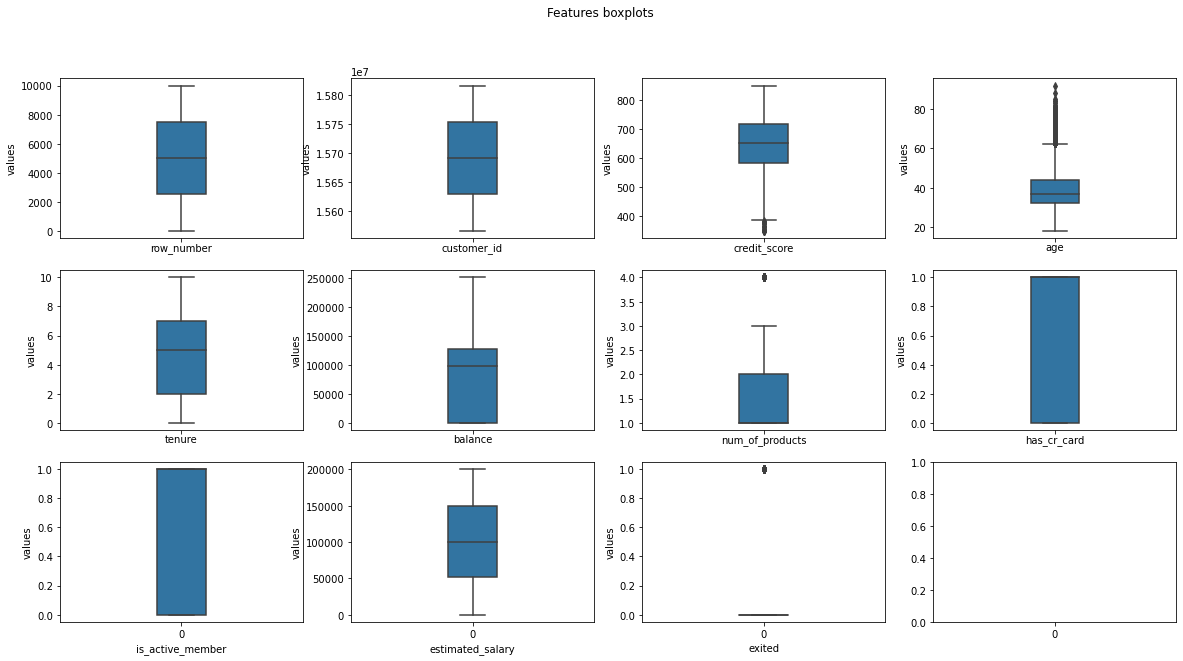

In [125]:
fig, axes = plt.subplots(3, 4, sharex=True, figsize=(20,10))
fig.suptitle('Features boxplots')
i=0
j=0
for x in data.columns:
    if data[x].dtype in ['float64', 'int64']:
        sns.boxplot(ax=axes[i][j],data = data[x]).set( xlabel = x, ylabel = 'values', xlim=(-2, 2))
        j+=1
        if j==4:
            i+=1
            j=0
        if i==3:
            break
plt.show()

Видим, что в значениях **credit_score, age, num_of_products** присутствуют выбросы, которые предстоит обработать. А также видно, что пресказываемый признак **exited** несбалансированный (объектов класса 0 значительно больше, чем объектов класса 1)

Природа выбросов такова, что это скорее просто редкие значения, а не какие-то аномалии. 

#### 1.5. Проверка мультиколлинеарности в признаках

In [126]:
sns.pairplot(data)
plt.show()

Построим матрицу попарно корреляции признаков, чтобы проверить, нет ли мультиколлинеарности в них.
По итогу рассмотрения можно видеть, что прямой корреляции в признаках не наблюдается, что означает, что ни один из признаков не является линейной комбинацией других.

#### 1.6. Удаление избыточных признаков

In [127]:
data=data.drop(columns=['row_number','customer_id','surname'])
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,france,female,42,2,0.00,1,1,1,101348.88,1
1,608,spain,female,41,1,83807.86,1,0,1,112542.58,0
2,502,france,female,42,8,159660.80,3,1,0,113931.57,1
3,699,france,female,39,1,0.00,2,0,0,93826.63,0
4,850,spain,female,43,2,125510.82,1,1,1,79084.10,0


Можно предположить, что столбцы **surname** и **customer_id** нет необходимости рассматривать в данной работе, как номинальные признаки они не несут большого веса в данном случае. Столбец **row_number** избыточный-его можно удалить.

#### 1.7. Кодирование признаков

In [128]:
data=pd.get_dummies(data, columns=['geography','gender'], drop_first=False)
data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_france,geography_germany,geography_spain,gender_female,gender_male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


Столбцы **geography** и **gender** были обработаны OHE-кодировщиком, для удобства работы модели с данными.


<div style="border:solid #4F6272 1px; padding: 4px">
По итогу раздела был осуществлен обзор датафрейма, найденные пропуски удалены, произведена проверка на наличие дубликатов, произведена проверка наличия выбросов, признаки проверены на мультиколлинеарность, удалены незначимые признаки,а категориальные признаки закодированы.

### 2. Исследование баланса классов, обучение модели без учёта дисбаланса.

#### 2.1. Разделение на тренировочную, тестовую и валидационную выборки

Для основного массива данных

In [129]:
features=data.drop(columns=['exited'])
target=data['exited']
train_features,test_features,train_target,test_target = train_test_split(features,target, test_size=0.2, random_state=12345)
train_features,valid_features,train_target,valid_target = train_test_split(train_features,train_target, test_size=0.22, random_state=12345)

print("Размеры тренировочной, валидационной,тестовой выборок:")
print(train_features.shape,valid_features.shape,test_features.shape)

Размеры тренировочной, валидационной,тестовой выборок:
(5672, 13) (1600, 13) (1819, 13)


#### 2.2. Маштабирование признаков

In [130]:
scaler = StandardScaler()
scaler.fit(train_features) 

train_features = scaler.transform(train_features)
valid_features = scaler.transform(valid_features)

print(train_features.shape)
print(train_target.shape)
pd.options.mode.chained_assignment = None

(5672, 13)
(5672,)


#### 2.3. Применение модели и проверка качества без учета дисбаланса классов

In [131]:
result_dict={'models':['LogisticRegression_voice','LogisticRegression_ups','DesigionTree_ups','RandomForest_ups','LogisticRegression_voice_b','DesigionTree_voice_b','RandomForest_voice_b'],
             'f1_score':[],
             'auc_roc':[]}

def update_results(s,a):
    result_dict['f1_score'].append(s)
    result_dict['auc_roc'].append(a)
    

#### 2.3.1 Логистическая регрессия

In [132]:
model_1=LogisticRegression(random_state=12345,solver='liblinear')
model_1.fit(train_features,train_target)

valid_predictions_1=model_1.predict(valid_features)
score_1=f1_score(valid_target,valid_predictions_1)
auc_roc_1=roc_auc_score(valid_target,model_1.predict_proba(valid_features)[:, 1])

update_results(score_1,auc_roc_1)

print('f1 score:',score_1)
print('AUC-ROC score:',auc_roc_1)

f1 score: 0.29268292682926833
AUC-ROC score: 0.7767583404500807


#### 2.3.2 Случайная модель

In [133]:
model_2 = DummyClassifier(random_state=12345,constant=1,strategy='constant')
model_2.fit(train_features, train_target)
valid_predictions_2=model_2.predict(valid_features)
score_2=f1_score(valid_target,valid_predictions_2)
auc_roc_2=roc_auc_score(valid_target,model_2.predict_proba(valid_features)[:, 1])

print('f1 score:',score_2)
print('AUC-ROC score:',auc_roc_1)

f1 score: 0.3219716832721552
AUC-ROC score: 0.7767583404500807


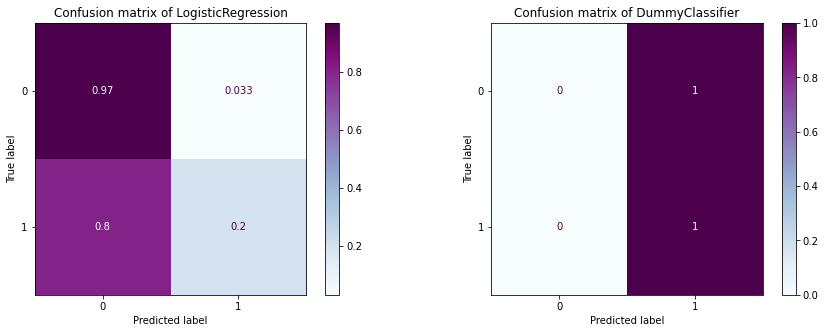

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].title.set_text('Confusion matrix of LogisticRegression')
axes[1].title.set_text('Confusion matrix of DummyClassifier')
plot_confusion_matrix(ax=axes[0], estimator=model_1, X=valid_features, y_true=valid_target, normalize='true', cmap='BuPu')
plot_confusion_matrix(ax=axes[1], estimator=model_2, X=valid_features, y_true=valid_target, normalize='true', cmap='BuPu')
plt.show()

#### 2.3.3 Персептрон с использованием кросс-валидации

In [135]:
perc_model = Perceptron(tol=1e-3, random_state=12345)
scores=[]
skf = StratifiedKFold(n_splits=5)
reshaped_train_target=np.array(train_target).reshape(-1,1)
for train_index, test_index in skf.split(train_features, train_target):
    train_f, test_f = train_features[train_index], train_features[test_index]
    train_t, test_t = reshaped_train_target[train_index], reshaped_train_target[test_index]
    perc_model.fit(train_f, train_t)
    test_predictions=perc_model.predict(test_f)
    score=f1_score(test_t,test_predictions)
    scores.append(score)
    
print('mean f1 score:', np.mean(scores))


mean f1 score: 0.33683638974601837


#### 2.3.4 Дисбаланс классов

Отобразим дисбаланс классов в зашумленных данных

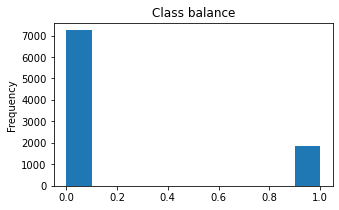

In [136]:
fig, axes = plt.subplots(1, 1, figsize=(5,3))
axes.title.set_text('Class balance')
target.plot.hist(ax=axes)
plt.show()

<div style="border:solid #4F6272 1px; padding: 4px">
    
В сравнении со случайной моделью рассмотренная модель имеет **f1_score** на 0.12 выше. Однако дисбаланс классов приводит к тому, что объекты 0 класса классифицируются верно в **96%** случаев, а для класса 1 только в **22%**. Также можем видеть, что модель, обученная на данных без выбросов выдает аналогичные показатели метрик f1 и AUC-ROC.

Объектов 0 класса примерно **в 4 раза больше**, чем первого. Чтобы улучшить качество модели необходимо устранить дисбаланс классов.



### 3. Улучшение качества модели, учитывая дисбаланс классов. Обучение разных моделей и поиск лучшей.

#### 3.1. Устранение дисбаланса классов методом Upsample

In [137]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = np.concatenate([features_zeros] + [features_ones] * repeat)
    target_upsampled = np.concatenate([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(train_features, train_target, 4)

##### 3.1.1 Модель логистической регрессии

In [138]:
def apply_model(model,train_f,train_t,valid_f,valid_t):
    model.fit(train_f,train_t)
    valid_p=model.predict(valid_f)
    score=f1_score(valid_t,valid_p)
    auc_roc=roc_auc_score(valid_t,model.predict_proba(valid_f)[:, 1])
    print('f1 score:',score)
    print('AUC-ROC score:',auc_roc)
    return (score, auc_roc)

In [139]:
model=LogisticRegression(solver='liblinear',random_state=12345)
scores, auc_rocs = apply_model(model,features_upsampled, target_upsampled,valid_features,valid_target)

update_results(scores, auc_rocs)

f1 score: 0.4875283446712018
AUC-ROC score: 0.778315207670468


Видим, что после **upsample** значение метрики f1 на валидационном множестве выросло на 0.12, что является показателем улучшения качества классификации.

##### 3.1.2. Модель дерева решений и случайного леса

In [140]:
models={'decisiontreeclassifier': DecisionTreeClassifier(),'randomforestclassifier': RandomForestClassifier(random_state=12345)}

grid = [{'max_depth': range(1,10)},{'n_estimators': range (10, 51, 10),
              'max_depth': range (1,21, 2),'min_samples_leaf': range (1,4),'min_samples_split':range(2,5,2)}]

scorers={
    'f1_score': make_scorer(f1_score),
    'auc_roc_score': make_scorer(roc_auc_score),
}

kf = KFold(n_splits=5, random_state=12345, shuffle=True)


In [141]:
def apply_gridsearch(models,grid,train_f,train_t,valid_f,valid_t):
    best_params=[]
    scores=[]
    auc_rocs=[]
    i=0
    for k in models.keys(): 
        imba_pipeline = make_pipeline(SMOTE(random_state=12345), models[k])
        new_params = {k + '__' + key: grid[i][key] for key in grid[i]}
        
        grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='f1')
        grid_imba.fit(train_f, train_t)
        
        print("\nbest model:",grid_imba.best_estimator_)
        valid_p = grid_imba.best_estimator_.named_steps[k].predict(valid_f)
        score = f1_score(valid_t,valid_p)
        auc_roc = roc_auc_score(valid_t,grid_imba.best_estimator_.predict_proba(valid_f)[:, 1])
        
        print("valid f1 score:",score)
        print('valid AUC-ROC score:',auc_roc)
        best_params.append(grid_imba.best_params_)
        scores.append(score)
        auc_rocs.append(auc_roc)
        i+=1
    
    return (best_params, scores, auc_rocs)



In [142]:
best_params, scores, auc_rocs = apply_gridsearch(models, grid, train_features, train_target, valid_features, valid_target)

for i in range(len(scores)):
    update_results(scores[i], auc_rocs[i])


best model: Pipeline(steps=[('smote', SMOTE(random_state=12345)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6))])
valid f1 score: 0.5584045584045584
valid AUC-ROC score: 0.8169093918392949

best model: Pipeline(steps=[('smote', SMOTE(random_state=12345)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=11, min_samples_leaf=3,
                                        n_estimators=40, random_state=12345))])
valid f1 score: 0.6032689450222882
valid AUC-ROC score: 0.8534630218843131


In [143]:
print(best_params[1])

{'randomforestclassifier__max_depth': 11, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 40}


Подбор гиперпараметров по сетке показал, что лучшая модель после техники **upsample** - это модель **случайного леса** с параметрами: 
* max_depth=11, 
* n_estimators=40,
* min_samples_split=2
* min_samples_leaf=3


#### 3.2. Устранение дисбаланса классов при помощи взвешивания

##### 3.2.1 Модель логистической регрессии

In [144]:
model=LogisticRegression(random_state=12345,solver='liblinear',class_weight='balanced')
scores, auc_rocs = apply_model(model,train_features,train_target,valid_features,valid_target)

update_results(scores, auc_rocs)

f1 score: 0.49365628604382933
AUC-ROC score: 0.7782774196311384


##### 3.2.1 Модель дерева решений и случайного леса

In [145]:
grid = [{'criterion': ['gini', 'entropy'], 'max_depth': range(1,10)},{'n_estimators': range (10, 51, 10),
              'max_depth': range (1,21),'min_samples_leaf': range (1,5),'min_samples_split':range(2,10,2)}]

models = [DecisionTreeClassifier(class_weight='balanced'),RandomForestClassifier(random_state=12345, class_weight='balanced')]

In [146]:
def apply_gridsearch_cv(models,grid,train_f,train_t,valid_f,valid_t):
    best_params=[]
    scores=[]
    auc_rocs=[]
    cross_val = StratifiedShuffleSplit(n_splits=5, random_state=12345)
    for i in range(len(models)):    
        grid_cv = GridSearchCV(estimator=models[i], param_grid = grid[i], scoring = 'f1', cv = cross_val, n_jobs=-1,refit=True)
        grid_cv.fit(train_f, train_t)
        print("best model:",grid_cv.best_estimator_)
        valid_p = grid_cv.best_estimator_.predict(valid_f)
        score = f1_score(valid_t,valid_p)
        auc_roc = roc_auc_score(valid_t,grid_cv.best_estimator_.predict_proba(valid_f)[:, 1])
        print("valid f1 score:",score)
        print('valid AUC-ROC score:',auc_roc)
        print("\n")
        best_params.append(grid_cv.best_params_)
        scores.append(score)
        auc_rocs.append(auc_roc)
        
    return (best_params, scores, auc_rocs)

In [147]:
best_params, scores ,auc_rocs = apply_gridsearch_cv(models,grid,train_features, train_target,valid_features,valid_target)

for i in range(len(scores)):
    update_results(scores[i], auc_rocs[i])

best model: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7)
valid f1 score: 0.5416666666666666
valid AUC-ROC score: 0.8175442309000357


best model: RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=6, n_estimators=50,
                       random_state=12345)
valid f1 score: 0.5917721518987341
valid AUC-ROC score: 0.8414300505603967




Подбор гиперпараметров по сетке с применением кросс-валидации показал, что лучшая модель для взвешенных классов - это модель **случайного леса** с параметрами:
* max_depth = 10, 
* min_samples_leaf = 4, 
* min_samples_split = 6, 
* n_estimators = 50 

#### 3.3 Результаты сравнения

In [148]:
results=pd.DataFrame(result_dict)
display(results)

,models,f1_score,auc_roc
0,LogisticRegression_voice,0.292683,0.776758
1,LogisticRegression_ups,0.487528,0.778315
2,DesigionTree_ups,0.558405,0.816909
3,RandomForest_ups,0.603269,0.853463
4,LogisticRegression_voice_b,0.493656,0.778277
5,DesigionTree_voice_b,0.541667,0.817544
6,RandomForest_voice_b,0.591772,0.841430


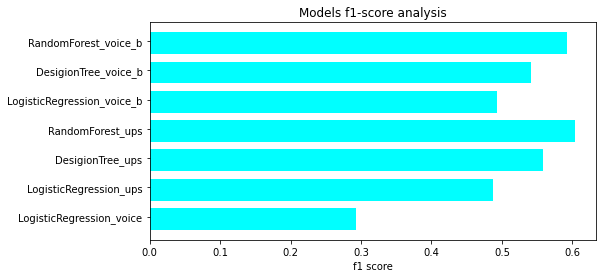

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

width = 0.75 # the width of the bars 
ind = np.arange(results.shape[0])  # the x locations for the groups
ax.set_yticks(ind + width/10)
ax.set_yticklabels(results['models'], minor=False)
ax.barh([x for x in range(results.shape[0])], results['f1_score'], width,color="cyan" )
plt.title('Models f1-score analysis')
plt.xlabel('f1 score')
plt.show()

<div style="border:solid #4F6272 1px; padding: 4px">
    
По итогу раздела лучшим способом устранения дисбаланса классов оказалась техника upsample, лучшим алгоритмом стала модель случайного леса с подобранными гиперпараметрами при помощи imblearn pipeline.

### 4. Проведение финального тестирования.

In [150]:
test_features= scaler.transform(test_features)

#### 4.1 Модель случайного леса с подобранными гиперпараметрами

In [151]:
forest_model=RandomForestClassifier(max_depth=11,n_estimators=40,min_samples_split=2, min_samples_leaf=3, random_state=12345)

apply_model(forest_model,train_features, train_target, test_features, test_target)


f1 score: 0.5431654676258992
AUC-ROC score: 0.8554153817400244


(0.5431654676258992, 0.8554153817400244)

Наилучшая модель случайного леса выдает падение метрики f1 score на тестовом множестве в сравнении с валидационным на 0.06, что говорит о том, что модель нормально обобщается на новые данные.

#### 4.2 Случайная модель

In [152]:
dummy_model = DummyClassifier(random_state=12345,constant=1,strategy='constant')
apply_model(dummy_model,train_features, train_target, test_features, test_target)

f1 score: 0.33729433272394876
AUC-ROC score: 0.5


(0.33729433272394876, 0.5)

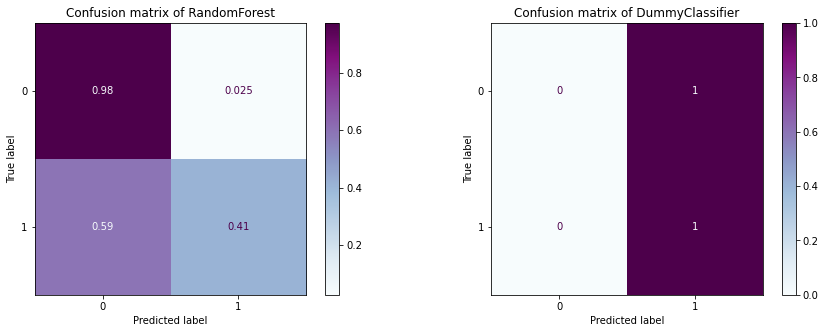

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].title.set_text('Confusion matrix of RandomForest')
axes[1].title.set_text('Confusion matrix of DummyClassifier')
plot_confusion_matrix(ax=axes[0], estimator=forest_model, X=test_features, y_true=test_target, normalize='true', cmap='BuPu')
plot_confusion_matrix(ax=axes[1], estimator=dummy_model, X=test_features, y_true=test_target, normalize='true', cmap='BuPu')
plt.show()

<Figure size 1080x360 with 0 Axes>

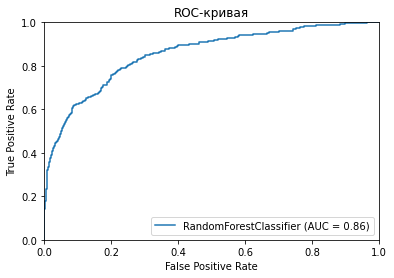

In [154]:
plt.figure(figsize=(15,5))
plot_roc_curve(forest_model,test_features, test_target) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 


В сравнении со случайной моделью полученная в ходе проекта модель показала лучший результат на тестовых данных.

#### 4.4 Наиболее важные признаки для полученной модели случайного леса

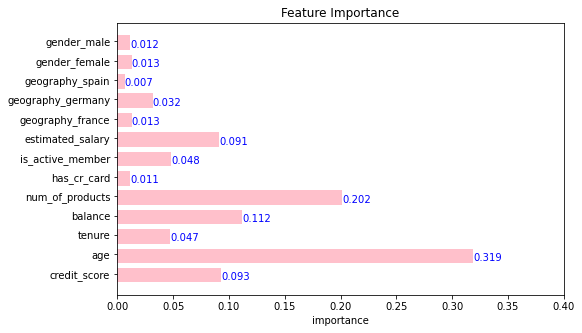

In [155]:
importance = forest_model.feature_importances_
x=features.columns
fig, ax = plt.subplots(1, 1, figsize=(8,5))

width = 0.75  
ind = np.arange(len(importance))
ax.set_yticks(ind + width/10)
ax.set_yticklabels(x, minor=False)
ax.set_xlim(0,0.4)
ax.barh([x for x in range(len(importance))], importance,width,color="pink" )

for i, v in enumerate(importance):
    ax.text( v, i-width/3, str(np.round(float(v),3)), color='blue')
    
plt.title('Feature Importance')
plt.xlabel('importance')
plt.show()

Таким образом наиболее значимыми признаками для полученной модели стали:

* age
* num_of_products
* balance
* estimated_salary
* credit_score

### 5. Выводы.

<div style="border:solid #9FEDD7 4px; padding: 40px">
    
Задачей исследования было построение модели предсказания ухода клиента из банка с предельно большим значением f1-меры (не менее 0.59).

В ходе исследования были изучены предоставленные данные, произведена предобработка данных, включая проверку на пропуски, дубликаты и выбросы, кодирование и маштабирование признаков.

Было рассмотрено, как влияет на значение метрики f1 **наличие/отсутствие дисбаланса** классов, а также был произведен поиск наилучшей модели при устраненном дисбалансе классов. Для моделей **случайного леса** и **дерева решений** с устраненным дисбалансом классов на upsample-множестве при помощи imblearn pipeline, а на взвешенном множестве при помощи при помощи перебора по сетке с использованием кросс-валидации,  были подобраны гиперпараметры, дающие наилучший результат на валидационном множестве. Затем модель, проявившая себя лучше всего на валидационном множестве была применена к тестовому множеству. Для иллюстрации построен график сравнения f1 метрики на различных моделях.
    
**При дисбалансе классов**
    
Модель линейной регрессии на данных с выбросами и без дала сопоставимые результаты со случайной моделью.

**При устраненном дисбалансе классов**
    
При устраненнии дисбаланса классов лучшей оказалась модель **дерева решений** с **upsample**. Модель дерева решений с  **взвешенными классами** выдала результат метрики f1 на 0.01 ниже, чем наилучшая модель. 
    
*Наилучшая модель:*
* f1 на валидационной выборке: **0.60**
* AUC-ROC на валидационной выборке: **0.85**

**Применение к тестовой выборке**
    
В ходе применения **наилучшей** полученной модели к тестовой выборке было произведено сопоставление с **константной** моделью. Для иллюстрации построена матрица ошибок.

*Наилучшая модель:*  
* f1 на тестовой выборке: **0.54** 
* AUC-ROC на тестовой выборке: **0.84**    
   

*Случайная модель:*
* f1 на тестовой выборке: **0.33**
* AUC-ROC на тестовой выборке: **0.5**
    
Для наилучшей модели был произведен анализ значимости признаков. Наиболее значимыми признаками оказались: возраст, количество продуктов у клиента, текущий баланс, предполагаемая зарплата и кредитный рейтинг.  
__________________________
Рекомендации: Для подбора модели с более высоким качеством имеет смысл рассмотреть также модели на основе стекинга и бустинга, также, если это возможно, попытаться дополнить исходное множество данных, на основе иных источников.